## 1. Import Libraries

In [2]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)
import matplotlib.pyplot as plt

#### to ignore warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

## 2. Display Settings

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
sklearn.set_config(transform_output="pandas")

## 3. Read the Data

In [6]:
path = r"C:\Users\Shivay\Desktop\flights-sagemaker-project\data\train.csv"
train = pd.read_csv(path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-05-21,Delhi,Cochin,14:05:00,17:55:00,230,0.0,No Info,6094
1,Indigo,2019-03-27,Delhi,Cochin,10:45:00,21:00:00,615,1.0,No Info,6838
2,Jet Airways,2019-05-12,Banglore,Delhi,19:50:00,22:50:00,180,0.0,No Info,7229
3,Jet Airways,2019-06-06,Kolkata,Banglore,20:25:00,14:25:00,1080,1.0,No Info,12692
4,Multiple Carriers,2019-05-15,Delhi,Cochin,11:40:00,19:15:00,455,1.0,No Info,9001


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          1600 non-null   object 
 1   date_of_journey  1600 non-null   object 
 2   source           1600 non-null   object 
 3   destination      1600 non-null   object 
 4   dep_time         1600 non-null   object 
 5   arrival_time     1600 non-null   object 
 6   duration         1600 non-null   int64  
 7   total_stops      1600 non-null   float64
 8   additional_info  1600 non-null   object 
 9   price            1600 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 125.1+ KB


#### seperating input features and target column

In [8]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

In [10]:
type(X_train),type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

## 4. Transformation Operations

### 4.1 airline

In [11]:
X_train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info'],
      dtype='object')

In [12]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [ ]:
# type(X_train["airline"]) # series

# type(X_train[["airline"]]) #DataFrame
# type(X_train.loc[:, ["airline"]]) #DataFrame

In [37]:
# air_transformer.fit_transform(X_train.loc[:, ["airline"]]).value_counts()  # also correct

In [38]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
1595,0.0,0.0,1.0,0.0,0.0
1596,0.0,0.0,1.0,0.0,0.0
1597,0.0,1.0,0.0,0.0,0.0
1598,0.0,0.0,0.0,1.0,0.0


### 4.2 date_of_journey

In [39]:
X_train.date_of_journey

0       2019-05-21
1       2019-03-27
2       2019-05-12
3       2019-06-06
4       2019-05-15
           ...    
1595    2019-05-03
1596    2019-05-06
1597    2019-03-03
1598    2019-03-21
1599    2019-03-15
Name: date_of_journey, Length: 1600, dtype: object

In [40]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.705882,0.166667,0.686441
1,0.000000,0.235294,0.333333,0.220339
2,0.666667,0.588235,1.000000,0.610169
3,1.000000,0.823529,0.500000,0.822034
4,0.666667,0.647059,0.333333,0.635593
...,...,...,...,...
1595,0.666667,0.529412,0.666667,0.533898
1596,0.666667,0.588235,0.000000,0.559322
1597,0.000000,0.000000,1.000000,0.016949
1598,0.000000,0.176471,0.500000,0.169492


### 4.3 source & destination

In [41]:
X_train.source

0          Delhi
1          Delhi
2       Banglore
3        Kolkata
4          Delhi
          ...   
1595    Banglore
1596     Kolkata
1597       Delhi
1598       Delhi
1599      Mumbai
Name: source, Length: 1600, dtype: object

In [42]:
X_train.destination

0          Cochin
1          Cochin
2           Delhi
3        Banglore
4          Cochin
          ...    
1595        Delhi
1596     Banglore
1597       Cochin
1598       Cochin
1599    Hyderabad
Name: destination, Length: 1600, dtype: object

In [43]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Banglore,Delhi
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
1595,Banglore,Delhi
1596,Kolkata,Banglore
1597,Delhi,Cochin
1598,Delhi,Cochin


In [44]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),  # needed y_train
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.019799,1.018865
1,1.019799,1.018865
2,-0.938081,-1.862572
3,-0.121222,-0.131749
4,1.019799,1.018865
...,...,...
1595,-0.938081,-1.862572
1596,-0.121222,-0.131749
1597,1.019799,1.018865
1598,1.019799,1.018865


In [47]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [48]:
def is_north(X):
	columns = X.columns.to_list()
    # let's assume north cities are as mentioned below since we have only 1 north city Delhi
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
1595,0,1
1596,1,0
1597,1,0
1598,1,0


In [49]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.019799,1.018865,1,0
1,1.019799,1.018865,1,0
2,-0.938081,-1.862572,0,1
3,-0.121222,-0.131749,1,0
4,1.019799,1.018865,1,0
...,...,...,...,...
1595,-0.938081,-1.862572,0,1
1596,-0.121222,-0.131749,1,0
1597,1.019799,1.018865,1,0
1598,1.019799,1.018865,1,0


### 4.4 dep_time & arrival_time

In [50]:
X_train.dep_time

0       14:05:00
1       10:45:00
2       19:50:00
3       20:25:00
4       11:40:00
          ...   
1595    06:00:00
1596    09:35:00
1597    18:35:00
1598    10:00:00
1599    22:45:00
Name: dep_time, Length: 1600, dtype: object

In [51]:
X_train.arrival_time

0       17:55:00
1       21:00:00
2       22:50:00
3       14:25:00
4       19:15:00
          ...   
1595    08:45:00
1596    23:35:00
1597    01:35:00
1598    19:15:00
1599    00:10:00
Name: arrival_time, Length: 1600, dtype: object

In [52]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,14:05:00,17:55:00
1,10:45:00,21:00:00
2,19:50:00,22:50:00
3,20:25:00,14:25:00
4,11:40:00,19:15:00
...,...,...
1595,06:00:00,08:45:00
1596,09:35:00,23:35:00
1597,18:35:00,01:35:00
1598,10:00:00,19:15:00


In [53]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"], format = 'mixed')),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset) 

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.608696,0.090909,0.739130,1.000000
1,0.434783,0.818182,0.913043,0.000000
2,0.826087,0.909091,0.956522,0.909091
3,0.869565,0.454545,0.608696,0.454545
4,0.478261,0.727273,0.826087,0.272727
...,...,...,...,...
1595,0.260870,0.000000,0.347826,0.818182
1596,0.391304,0.636364,1.000000,0.636364
1597,0.782609,0.636364,0.043478,0.636364
1598,0.434783,0.000000,0.826087,0.272727


#### Adding new feature part_of_day

In [54]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col], format = 'mixed').dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,evening
1,morning,night
2,evening,night
3,night,afternoon
4,morning,evening
...,...,...
1595,morning,morning
1596,morning,night
1597,evening,night
1598,morning,evening


In [55]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.586957
1,1.000000,1.000000
2,0.197697,1.000000
3,0.107486,0.000000
4,1.000000,0.586957
...,...,...
1595,1.000000,0.891304
1596,1.000000,1.000000
1597,0.197697,1.000000
1598,1.000000,0.586957


#### Applying feature union between time_pipe1,time_pipe2

In [56]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset) 

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.608696,0.090909,0.739130,1.000000,0.000000,0.586957
1,0.434783,0.818182,0.913043,0.000000,1.000000,1.000000
2,0.826087,0.909091,0.956522,0.909091,0.197697,1.000000
3,0.869565,0.454545,0.608696,0.454545,0.107486,0.000000
4,0.478261,0.727273,0.826087,0.272727,1.000000,0.586957
...,...,...,...,...,...,...
1595,0.260870,0.000000,0.347826,0.818182,1.000000,0.891304
1596,0.391304,0.636364,1.000000,0.636364,1.000000,1.000000
1597,0.782609,0.636364,0.043478,0.636364,0.197697,1.000000
1598,0.434783,0.000000,0.826087,0.272727,1.000000,0.586957


### 4.5 duration

In [57]:
X_train.duration

0        230
1        615
2        180
3       1080
4        455
        ... 
1595     165
1596     840
1597     420
1598     555
1599      85
Name: duration, Length: 1600, dtype: int64

In [58]:
class RBFPercentileSimilarity():
    def __init__(self):
        pass   

In [59]:
RBFPercentileSimilarity()

In [60]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin): 
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
    def fit(self, X, y=None):
        # if user has not given any variables
        if not self.variables:
            # selecting all numeric cols from given df
            self.variables = X.select_dtypes(include="number").columns.to_list()
            
        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }
    
        return self
        
    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
            objects.append(obj)
        return pd.concat(objects, axis=1)    

In [61]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,3.859327e-138,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00
2,2.011579e-02,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,2.669190e-109,0.000000e+00
...,...,...,...
1595,4.730781e-04,0.000000e+00,0.000000e+00
1596,0.000000e+00,0.000000e+00,1.125982e-278
1597,0.000000e+00,1.668157e-314,0.000000e+00
1598,0.000000e+00,2.669190e-109,0.000000e+00


In [62]:
# giving df
RBFPercentileSimilarity().fit_transform(X_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,3.859327e-138,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837
1,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
2,2.011579e-02,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837
3,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
4,0.000000e+00,2.669190e-109,0.000000e+00,0.904837,1.000000,1.000000
...,...,...,...,...,...,...
1595,4.730781e-04,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837
1596,0.000000e+00,0.000000e+00,1.125982e-278,0.904837,1.000000,1.000000
1597,0.000000e+00,1.668157e-314,0.000000e+00,0.904837,1.000000,1.000000
1598,0.000000e+00,2.669190e-109,0.000000e+00,0.904837,1.000000,1.000000


In [63]:
# for 40 and 80 percentile.
RBFPercentileSimilarity(percentiles = [0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.000000,0.904837,0.904837
1,0.000000e+00,0.000000,1.000000,1.000000
2,0.000000e+00,0.000000,0.904837,0.904837
3,0.000000e+00,0.000304,1.000000,1.000000
4,0.000000e+00,0.000000,1.000000,1.000000
...,...,...,...,...
1595,0.000000e+00,0.000000,0.904837,0.904837
1596,0.000000e+00,0.000000,1.000000,1.000000
1597,4.508027e-157,0.000000,1.000000,1.000000
1598,0.000000e+00,0.000000,1.000000,1.000000


In [64]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
    # to convert in array
	.values
    # reshaping 1-d array to 2-d matrix having any no of rows but 1 col.
	.reshape(-1, 1)
	# .shape 
)

array([[173.75],
       [505.  ],
       [920.  ]])

In [65]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [66]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [67]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])
# handleing outlier and missing value
duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.328770,-0.115932,-0.101315,1.0,0,-0.807925
1,-0.328770,-0.115932,-0.101315,2.0,0,-0.027156
2,1.412739,-0.115932,-0.101315,1.0,0,-0.909323
3,-0.328770,-0.115932,-0.101315,2.0,1,0.915851
4,-0.328770,-0.115932,-0.101315,2.0,0,-0.351631
...,...,...,...,...,...,...
1595,-0.272984,-0.115932,-0.101315,0.0,0,-0.939743
1596,-0.328770,-0.115932,-0.101315,2.0,0,0.429138
1597,-0.328770,-0.115932,-0.101315,2.0,0,-0.422610
1598,-0.328770,-0.115932,-0.101315,2.0,0,-0.148834


### 4.6 total_stops

In [68]:
X_train.total_stops

0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
1595    0.0
1596    1.0
1597    1.0
1598    1.0
1599    0.0
Name: total_stops, Length: 1600, dtype: float64

In [69]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
1595,0.0,1
1596,1.0,0
1597,1.0,0
1598,1.0,0


### 4.7 additional_info

In [70]:
X_train.additional_info

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
1595                        No Info
1596                        No Info
1597                        No Info
1598    In-flight meal not included
1599                        No Info
Name: additional_info, Length: 1600, dtype: object

In [71]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
1595,0.0,1.0,0.0
1596,0.0,1.0,0.0
1597,0.0,1.0,0.0
1598,1.0,0.0,0.0


In [72]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [73]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [74]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
1595,0.0,1.0,0.0,0
1596,0.0,1.0,0.0,0
1597,0.0,1.0,0.0,0
1598,1.0,0.0,0.0,1


In [75]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.8 Column Transformer

In [76]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")
column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.019799,1.018865,1,0,0.608696,0.090909,0.739130,1.000000,0.000000,0.586957,-0.328770,-0.115932,-0.101315,1.0,0,-0.807925,0.0,1,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.019799,1.018865,1,0,0.434783,0.818182,0.913043,0.000000,1.000000,1.000000,-0.328770,-0.115932,-0.101315,2.0,0,-0.027156,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.938081,-1.862572,0,1,0.826087,0.909091,0.956522,0.909091,0.197697,1.000000,1.412739,-0.115932,-0.101315,1.0,0,-0.909323,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.121222,-0.131749,1,0,0.869565,0.454545,0.608696,0.454545,0.107486,0.000000,-0.328770,-0.115932,-0.101315,2.0,1,0.915851,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.333333,0.635593,1.019799,1.018865,1,0,0.478261,0.727273,0.826087,0.272727,1.000000,0.586957,-0.328770,-0.115932,-0.101315,2.0,0,-0.351631,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-0.938081,-1.862572,0,1,0.260870,0.000000,0.347826,0.818182,1.000000,0.891304,-0.272984,-0.115932,-0.101315,0.0,0,-0.939743,0.0,1,0.0,1.0,0.0,0
1596,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.121222,-0.131749,1,0,0.391304,0.636364,1.000000,0.636364,1.000000,1.000000,-0.328770,-0.115932,-0.101315,2.0,0,0.429138,1.0,0,0.0,1.0,0.0,0
1597,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.019799,1.018865,1,0,0.782609,0.636364,0.043478,0.636364,0.197697,1.000000,-0.328770,-0.115932,-0.101315,2.0,0,-0.422610,1.0,0,0.0,1.0,0.0,0
1598,0.0,0.0,0.0,1.0,0.0,0.000000,0.176471,0.500000,0.169492,1.019799,1.018865,1,0,0.434783,0.000000,0.826087,0.272727,1.000000,0.586957,-0.328770,-0.115932,-0.101315,2.0,0,-0.148834,1.0,0,1.0,0.0,0.0,1


## 5. Feature Selection

In [85]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 
# 'selector'-selects only those columns whose 'r2' score is 10% or greater

## 6. Putting it all Together

In [86]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)
# put all selected cols together

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.666667,0.705882,0.686441,1.019799,1.018865,-0.328770,1.0,0,-0.807925,0.0,1
1,1.0,0.0,0.0,0.000000,0.235294,0.220339,1.019799,1.018865,-0.328770,2.0,0,-0.027156,1.0,0
2,0.0,1.0,0.0,0.666667,0.588235,0.610169,-0.938081,-1.862572,1.412739,1.0,0,-0.909323,0.0,1
3,0.0,1.0,0.0,1.000000,0.823529,0.822034,-0.121222,-0.131749,-0.328770,2.0,1,0.915851,1.0,0
4,0.0,0.0,0.0,0.666667,0.647059,0.635593,1.019799,1.018865,-0.328770,2.0,0,-0.351631,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.666667,0.529412,0.533898,-0.938081,-1.862572,-0.272984,0.0,0,-0.939743,0.0,1
1596,0.0,1.0,0.0,0.666667,0.588235,0.559322,-0.121222,-0.131749,-0.328770,2.0,0,0.429138,1.0,0
1597,1.0,0.0,0.0,0.000000,0.000000,0.016949,1.019799,1.018865,-0.328770,2.0,0,-0.422610,1.0,0
1598,0.0,0.0,0.0,0.000000,0.176471,0.169492,1.019799,1.018865,-0.328770,2.0,0,-0.148834,1.0,0


## 7. Visualizations

In [79]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x0000024B8B6211C0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [80]:
preprocessor.named_steps

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='Other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

In [81]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [82]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.001714423486973075,
 'air__airline_Indigo': 0.16093233527435788,
 'air__airline_Jet Airways': 0.20199144485335307,
 'air__airline_Multiple Carriers': 0.023451147694139213,
 'air__airline_Other': 0.12802385853364442,
 'doj__date_of_journey_month': 0.10686337772472687,
 'doj__date_of_journey_week': 0.21854660437571002,
 'doj__date_of_journey_day_of_week': 0.004720156827760095,
 'doj__date_of_journey_day_of_year': 0.2594383088466547,
 'location__source': 0.13392961009113014,
 'location__destination': 0.13697171032591582,
 'location__source_is_north': 0.030087679947447654,
 'location__destination_is_north': 0.030087679947447654,
 'time__dep_time_hour': 0.007776363855027187,
 'time__dep_time_minute': 0.036152900981194024,
 'time__arrival_time_hour': 0.09690460144778294,
 'time__arrival_time_minute': 0.024015282330996368,
 'time__dep_time_part_of_day': -0.0042472931834349375,
 'time__arrival_time_part_of_day': 0.026789269629040602,
 'dur__duration_rbf_25': 0.1272

In [83]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_75': -0.0046669635879326155,
 'time__dep_time_part_of_day': -0.0042472931834349375,
 'info__additional_info_No Info': -0.003936409867714079,
 'info__additional_info': -0.003936409867714079,
 'info__additional_info_In-flight meal not included': -1.1456592272788649e-05,
 'air__airline_Air India': 0.001714423486973075,
 'dur__duration_rbf_50': 0.0039929641021591395,
 'doj__date_of_journey_day_of_week': 0.004720156827760095,
 'time__dep_time_hour': 0.007776363855027187,
 'info__additional_info_Other': 0.009850010538166401,
 'air__airline_Multiple Carriers': 0.023451147694139213,
 'time__arrival_time_minute': 0.024015282330996368,
 'time__arrival_time_part_of_day': 0.026789269629040602,
 'location__source_is_north': 0.030087679947447654,
 'location__destination_is_north': 0.030087679947447654,
 'time__dep_time_minute': 0.036152900981194024,
 'time__arrival_time_hour': 0.09690460144778294,
 'doj__date_of_journey_month': 0.10686337772472687,
 'dur__duration_rbf_25': 0.1272

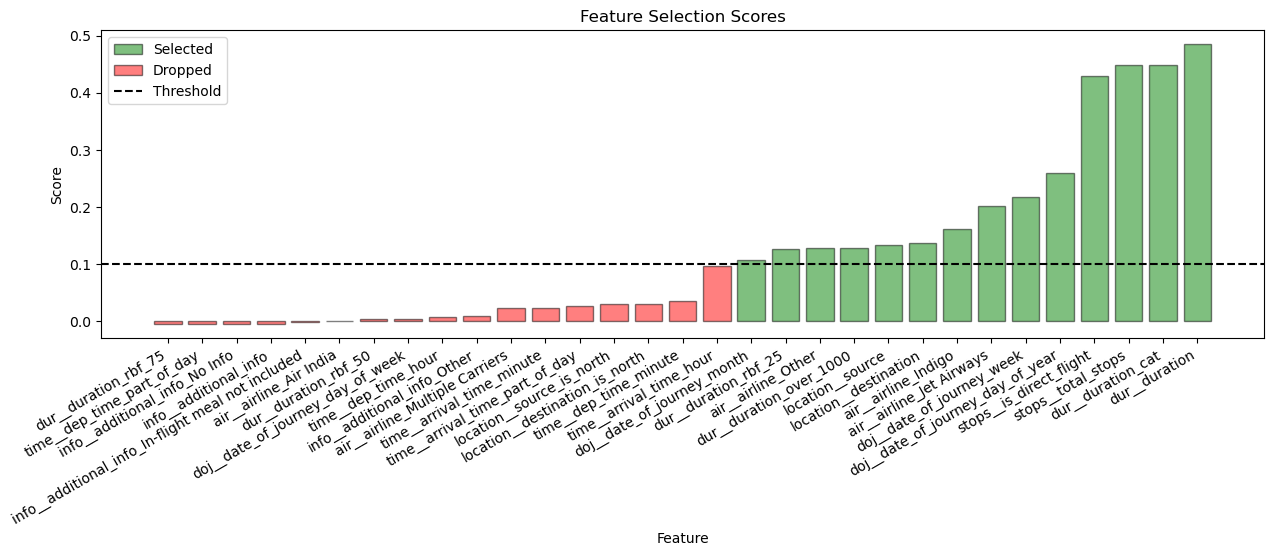

In [84]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that